# Rule Based and Market Baseket Analysis Recommendation systems 

Rule based recommendar systems use pre-defined rules to recommend product/items to users. These rules are based on factors such as popularity , discount & offers, new product launches, trending items based on demographic factors.

Market Basket Analysis is a type of recommender systems which uses association rules to determine the association between items that are frequently bought together in a single transaction. It uses various algorithms such as Apirori to determine the frequent itemsets with the help of confidence rules. 

In [1]:
!pip install networkx>=2.5

In [2]:
!pip install mlxtend==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00


In [3]:
! pip install wordcloud

In [4]:
#Importing Necessary libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from mlxtend.frequent_patterns import apriori,association_rules
from collections import Counter
from IPython.display import Image, display
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Exploratory Data Analysis ( EDA) 

In [5]:
#Loading the dataset 
df=pd.read_csv('data.csv',encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.info() # get the basic information of the df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.isnull().sum() # count the null values 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df_new = df.dropna(subset=['Description'])# drop the null values 

In [9]:
df_new.describe()# Check descriptive statistocs 

,Quantity,UnitPrice,CustomerID
count,540455.000000,540455.000000,406829.000000
mean,9.603129,4.623519,15287.690570
std,218.007598,96.889628,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Some quantities are negative, which may indicate either inaccurate data or product returns. When building a recommendation system, it's crucial to focus only on completed transactions involving non-returned items. This ensures that the recommendations are based on products genuinely purchased and retained by customers, helping to avoid revenue fluctuations and better reflect consumer satisfaction and demand. So that, records onnly with the product quantity greater than zero are considered in this project. 

In [10]:
df_new=df_new[df_new['Quantity']>0]

In [11]:
df_new.describe() # verify that the minimum purchased quantity at least greater than zero 

,Quantity,UnitPrice,CustomerID
count,530693.000000,530693.000000,397924.000000
mean,10.605819,3.861599,15294.315171
std,156.637853,41.833162,1713.169877
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


### Extracting Customer Insights from the dataset

1. Find most loyal customers : Depends on who made the most number of transactions frequently
2. customers contribute to the most of revenue : Depends on value of the total transactions made
3. Customer purchasing patterns based on seasonality : Based on date and time when the orders were placed
4. Discount based : Number of orders made by customers when free items or discounted items are available

In [12]:
df_new['Amount']=df_new['Quantity']*df_new['UnitPrice']
import datetime
# Convert the 'InvoiceDate' column to datetime object to extract the month 
df_new['InvoiceDate'] = pd.to_datetime(df_new.InvoiceDate, format='%m/%d/%Y %H:%M')
df_new.insert(loc=2, column='year_month', value=df_new['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.InvoiceDate.dt.month)
df_new.insert(loc=4, column='day', value=(df_new.InvoiceDate.dt.dayofweek)+1)

1. Find most loyal Customers

In [13]:
 # Find the most loyal customers 
orders= df_new.groupby(by=['CustomerID','Country'],as_index=False)['InvoiceNo'].count() 
print('Top 10 loyal customers with most number of orders are :')
orders.sort_values(by='InvoiceNo',ascending=False).head(10)

Top 10 loyal customers with most number of orders are :


,CustomerID,Country,InvoiceNo
4019,17841.0,United Kingdom,7847
1888,14911.0,EIRE,5677
1298,14096.0,United Kingdom,5111
334,12748.0,United Kingdom,4596
1670,14606.0,United Kingdom,2700
2185,15311.0,United Kingdom,2379
1698,14646.0,Netherlands,2080
570,13089.0,United Kingdom,1818
699,13263.0,United Kingdom,1677
1443,14298.0,United Kingdom,1637


2. Find customers contributed to the most revenue

In [14]:
# Find the customers who contribute most to the revenue 
money_spent=df_new.groupby(['CustomerID','Country'],as_index=False)['Amount'].sum()
print('Top 10 most profitable customers with highest money spent are :')
money_spent.sort_values(by='Amount', ascending=False).head(10)

Top 10 most profitable customers with highest money spent are :


,CustomerID,Country,Amount
1698,14646.0,Netherlands,280206.02
4210,18102.0,United Kingdom,259657.30
3737,17450.0,United Kingdom,194550.79
3017,16446.0,United Kingdom,168472.50
1888,14911.0,EIRE,143825.06
57,12415.0,Australia,124914.53
1342,14156.0,EIRE,117379.63
3780,17511.0,United Kingdom,91062.38
2711,16029.0,United Kingdom,81024.84
0,12346.0,United Kingdom,77183.60


3a. Customer Purchase Patterns- yearly based

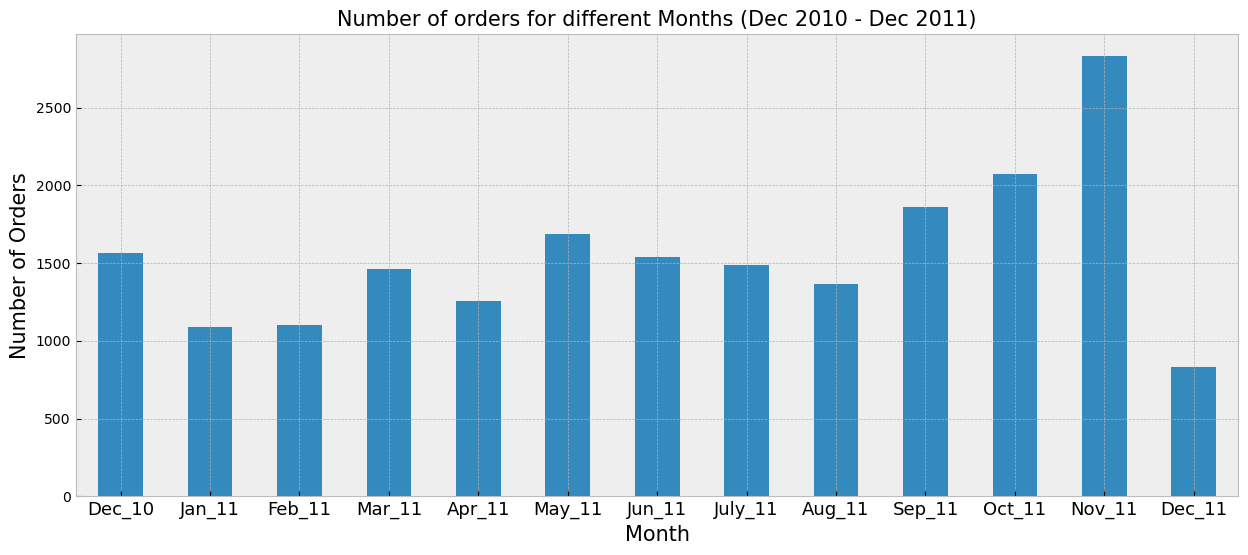

In [15]:
# Plot customer purchase patterns based on yearly

plt.style.use('bmh') #bmh style for better visualization

# Using groupby to extract No. of Invoices year-monthwise
ax = df_new.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

3b. Customer Purchase Patterns -monthly based

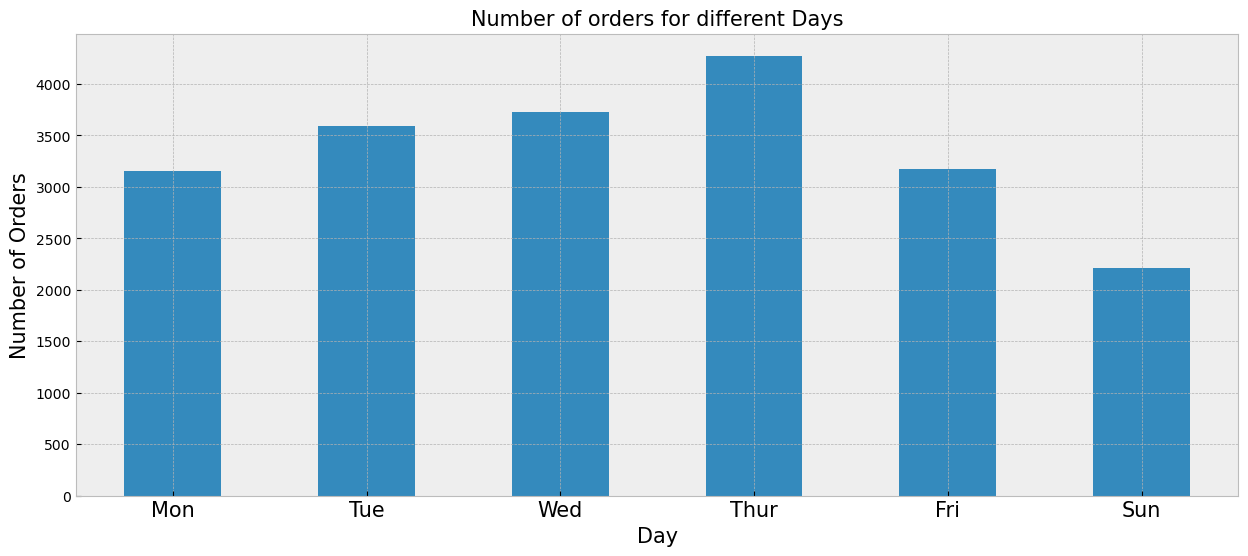

In [16]:
# Plot daily based customer purchase patterns 

ax = df_new.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot(kind='bar',figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)

ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)

plt.show()

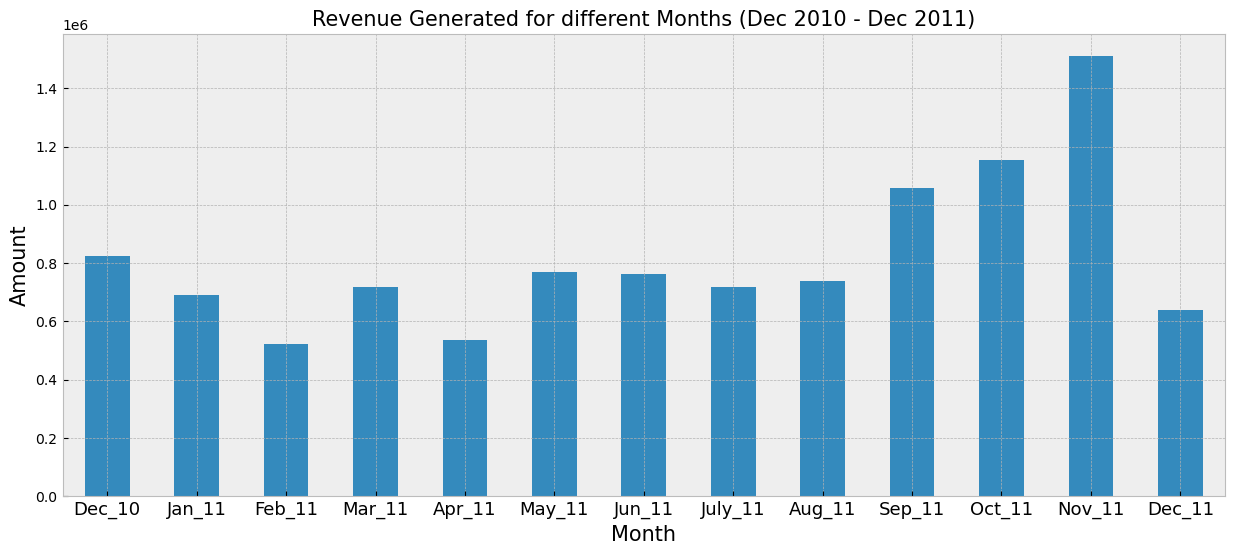

In [17]:
# plot revenue generated in yearly based 

plt.style.use('bmh')
ax = df_new.groupby('year_month')['Amount'].sum().sort_index().plot(kind='bar',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Amount',fontsize=15)

ax.set_title('Revenue Generated for different Months (Dec 2010 - Dec 2011)',fontsize=15)

# Providing with X tick labels
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)

plt.show()

4. Free items and sales
   
Finds how discounted offers or free items impacted the amount of orders placed by the customers. After analyszing the distribution of the unit prices of the itesm, it can be seen a higher volume of items are densed around the unit price of zero. So, those items are considered as the free items. 

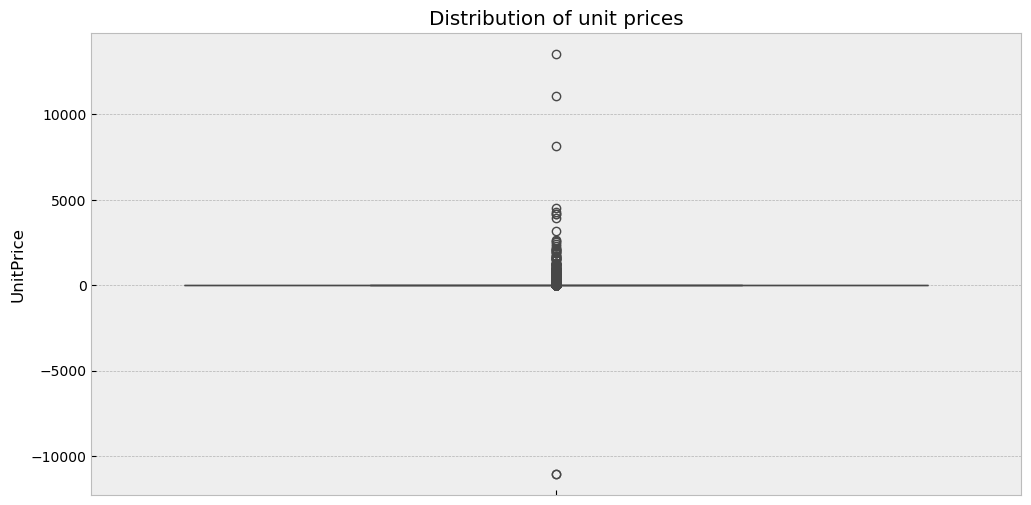

In [18]:
# checking the distribution of unit price
plt.subplots(figsize=(12,6))
sns.set_style('darkgrid')
sns.boxplot(df_new.UnitPrice)
plt.title('Distribution of unit prices')

plt.show()

In [19]:
# Extract free items from the dataset
free_items = df_new[df_new['UnitPrice'] == 0]

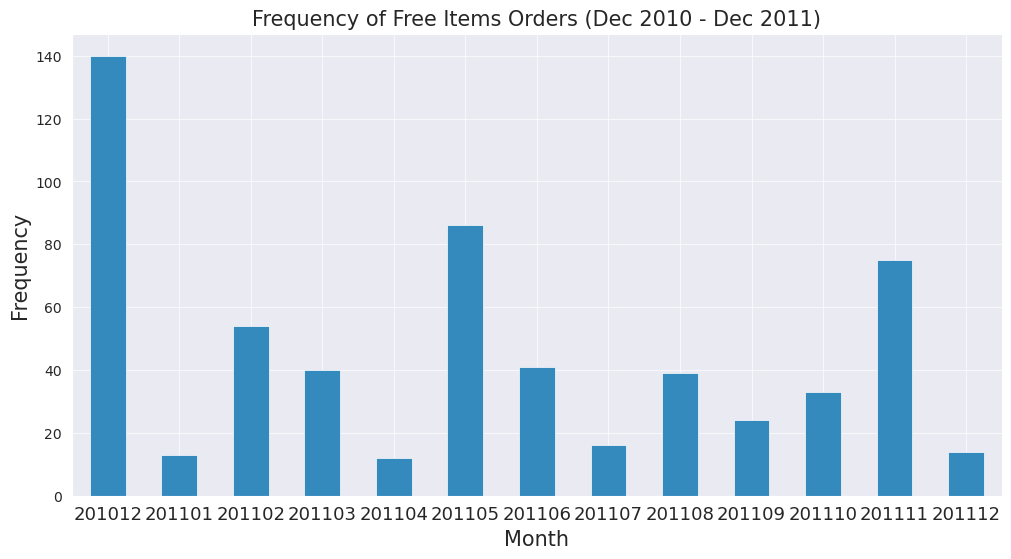

In [20]:
# Counting how many free items were given out year-month wise
free_items.year_month.value_counts().sort_index().plot(kind='bar', figsize=(12,6))

plt.xlabel('Month', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Frequency of Free Items Orders (Dec 2010 - Dec 2011)', fontsize=15)
plt.xticks(rotation='horizontal', fontsize=13)

plt.show()

### Extracting Item Insights from the dataset

1. Which item is bought by most no. of customers?
2. Which is the most sold item based on sum of sales?
3. Which is the most sold item based on the count of orders?
4. Which items are the first choice items for most no. of invoices?



#### 1.Items bought by Most customers 

In [21]:
df_most_items=df_new.pivot_table(index=['StockCode','Description'],values='CustomerID',aggfunc =lambda x: len(x.unique())).sort_values(by=
'CustomerID',ascending=False)
print('Top 10 items bought by most customers :')
df_most_items.head(10)


Top 10 items bought by most customers :


,,CustomerID
StockCode,Description,
22423,REGENCY CAKESTAND 3 TIER,882
85123A,WHITE HANGING HEART T-LIGHT HOLDER,857
47566,PARTY BUNTING,709
84879,ASSORTED COLOUR BIRD ORNAMENT,679
22720,SET OF 3 CAKE TINS PANTRY DESIGN,641
85099B,JUMBO BAG RED RETROSPOT,636
21212,PACK OF 72 RETROSPOT CAKE CASES,636
22086,PAPER CHAIN KIT 50'S CHRISTMAS,614
22457,NATURAL SLATE HEART CHALKBOARD,588


/tmp/ipykernel_8994/3018113586.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Description', x='CustomerID', data=df_most_items.head(10),palette='Spectral')


Text(0, 0.5, 'Item')

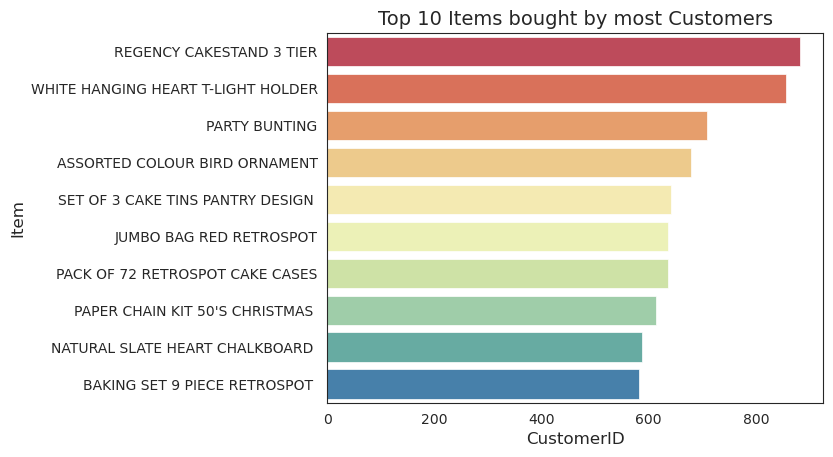

In [22]:
# Plot the graph for top items bought by most customers
df_most_items.reset_index(inplace=True)
sns.set_style('white')
sns.barplot(y='Description', x='CustomerID', data=df_most_items.head(10),palette='Spectral')
plt.title('Top 10 Items bought by most Customers', fontsize=14)

plt.ylabel('Item')

#### 2. Most sold items based on the sales 

In [23]:
most_sold_df=df_new.pivot_table(index=['StockCode','Description'],values='Quantity',aggfunc='sum').sort_values(by='Quantity',ascending=False)
print('Top 10 most sold items based on the Qunaity/ sales:')
most_sold_df.head(10)

Top 10 most sold items based on the Qunaity/ sales:


,,Quantity
StockCode,Description,
23843,"PAPER CRAFT , LITTLE BIRDIE",80995
23166,MEDIUM CERAMIC TOP STORAGE JAR,78033
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
85099B,JUMBO BAG RED RETROSPOT,48478
85123A,WHITE HANGING HEART T-LIGHT HOLDER,37603
22197,POPCORN HOLDER,36761
84879,ASSORTED COLOUR BIRD ORNAMENT,36461
21212,PACK OF 72 RETROSPOT CAKE CASES,36419
23084,RABBIT NIGHT LIGHT,30788


/tmp/ipykernel_8994/1284532417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Description', x='Quantity', data=most_sold_df.head(10),palette='Reds')


Text(0, 0.5, 'Item')

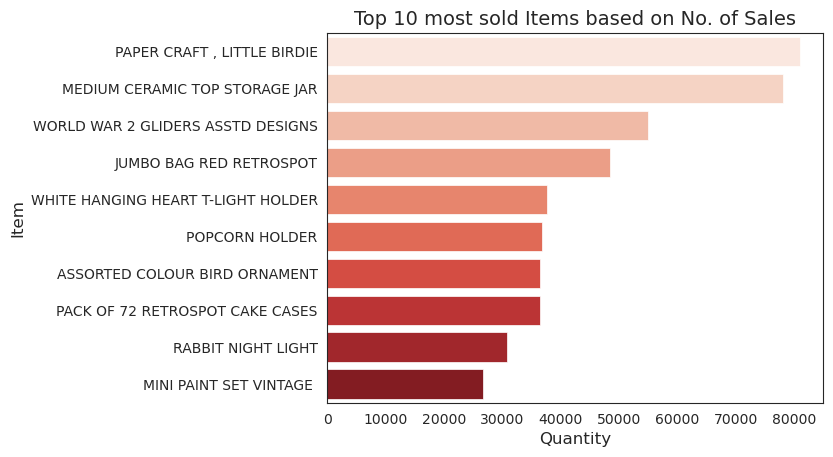

In [24]:
# Plot the graph for top most sold items based on Sales 
sns.set_style('white')
sns.barplot(y='Description', x='Quantity', data=most_sold_df.head(10),palette='Reds')
plt.title('Top 10 most sold Items based on No. of Sales', fontsize=14)

plt.ylabel('Item')

#### 3.Most sold item based on the count of orders

In [25]:
most_sold_df2=df_new.pivot_table(index=['StockCode','Description'],values='InvoiceNo',aggfunc='sum').sort_values(by='InvoiceNo',ascending=False)
most_sold_df2['Ordercount']=most_sold_df2['InvoiceNo'].apply(lambda x: len(x))
print('Top 10 most sold items based on the count of Orders:')
most_sold_df2.head(10)

Top 10 most sold items based on the count of Orders:


,,InvoiceNo,Ordercount
StockCode,Description,,
B,Adjust bad debt,A563185A563186A563187,21
23843,"PAPER CRAFT , LITTLE BIRDIE",581483,6
85123A,CREAM HANGING HEART T-LIGHT HOLDER,5813345813955814025814045814125814325814395814...,54
47591b,SCOTTIES CHILDRENS APRON,581238,6
22142,check,581211,6
23404,check,581202,6
90214U,"LETTER ""U"" BLING KEY RING",580691,6
22927,Amazon,580609,6
21804,dotcom,580586,6


/tmp/ipykernel_8994/3249267196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Description', x='Ordercount', data=most_sold_df2.head(10),palette='Greens')


Text(0, 0.5, 'Item')

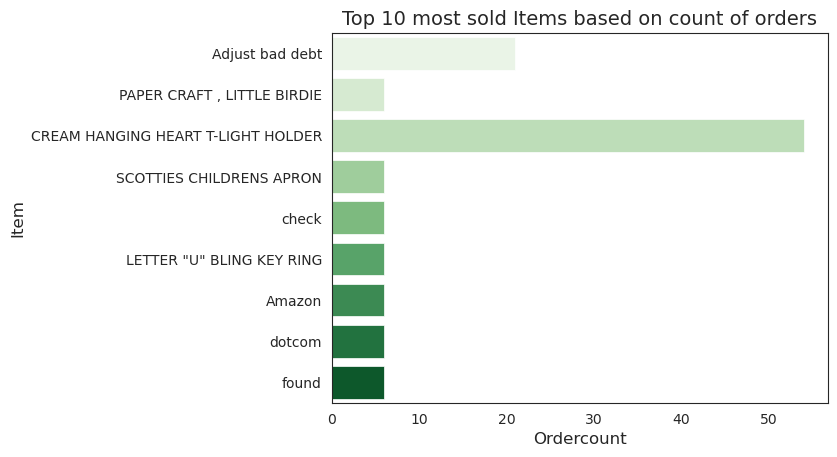

In [26]:
# Plot the graph for top most sold items based on Count of Orders  
most_sold_df2.reset_index(inplace=True)
sns.set_style('white')
sns.barplot(y='Description', x='Ordercount', data=most_sold_df2.head(10),palette='Greens')
plt.title('Top 10 most sold Items based on count of orders', fontsize=14)

plt.ylabel('Item')

#### Most Frequently Ordered Items

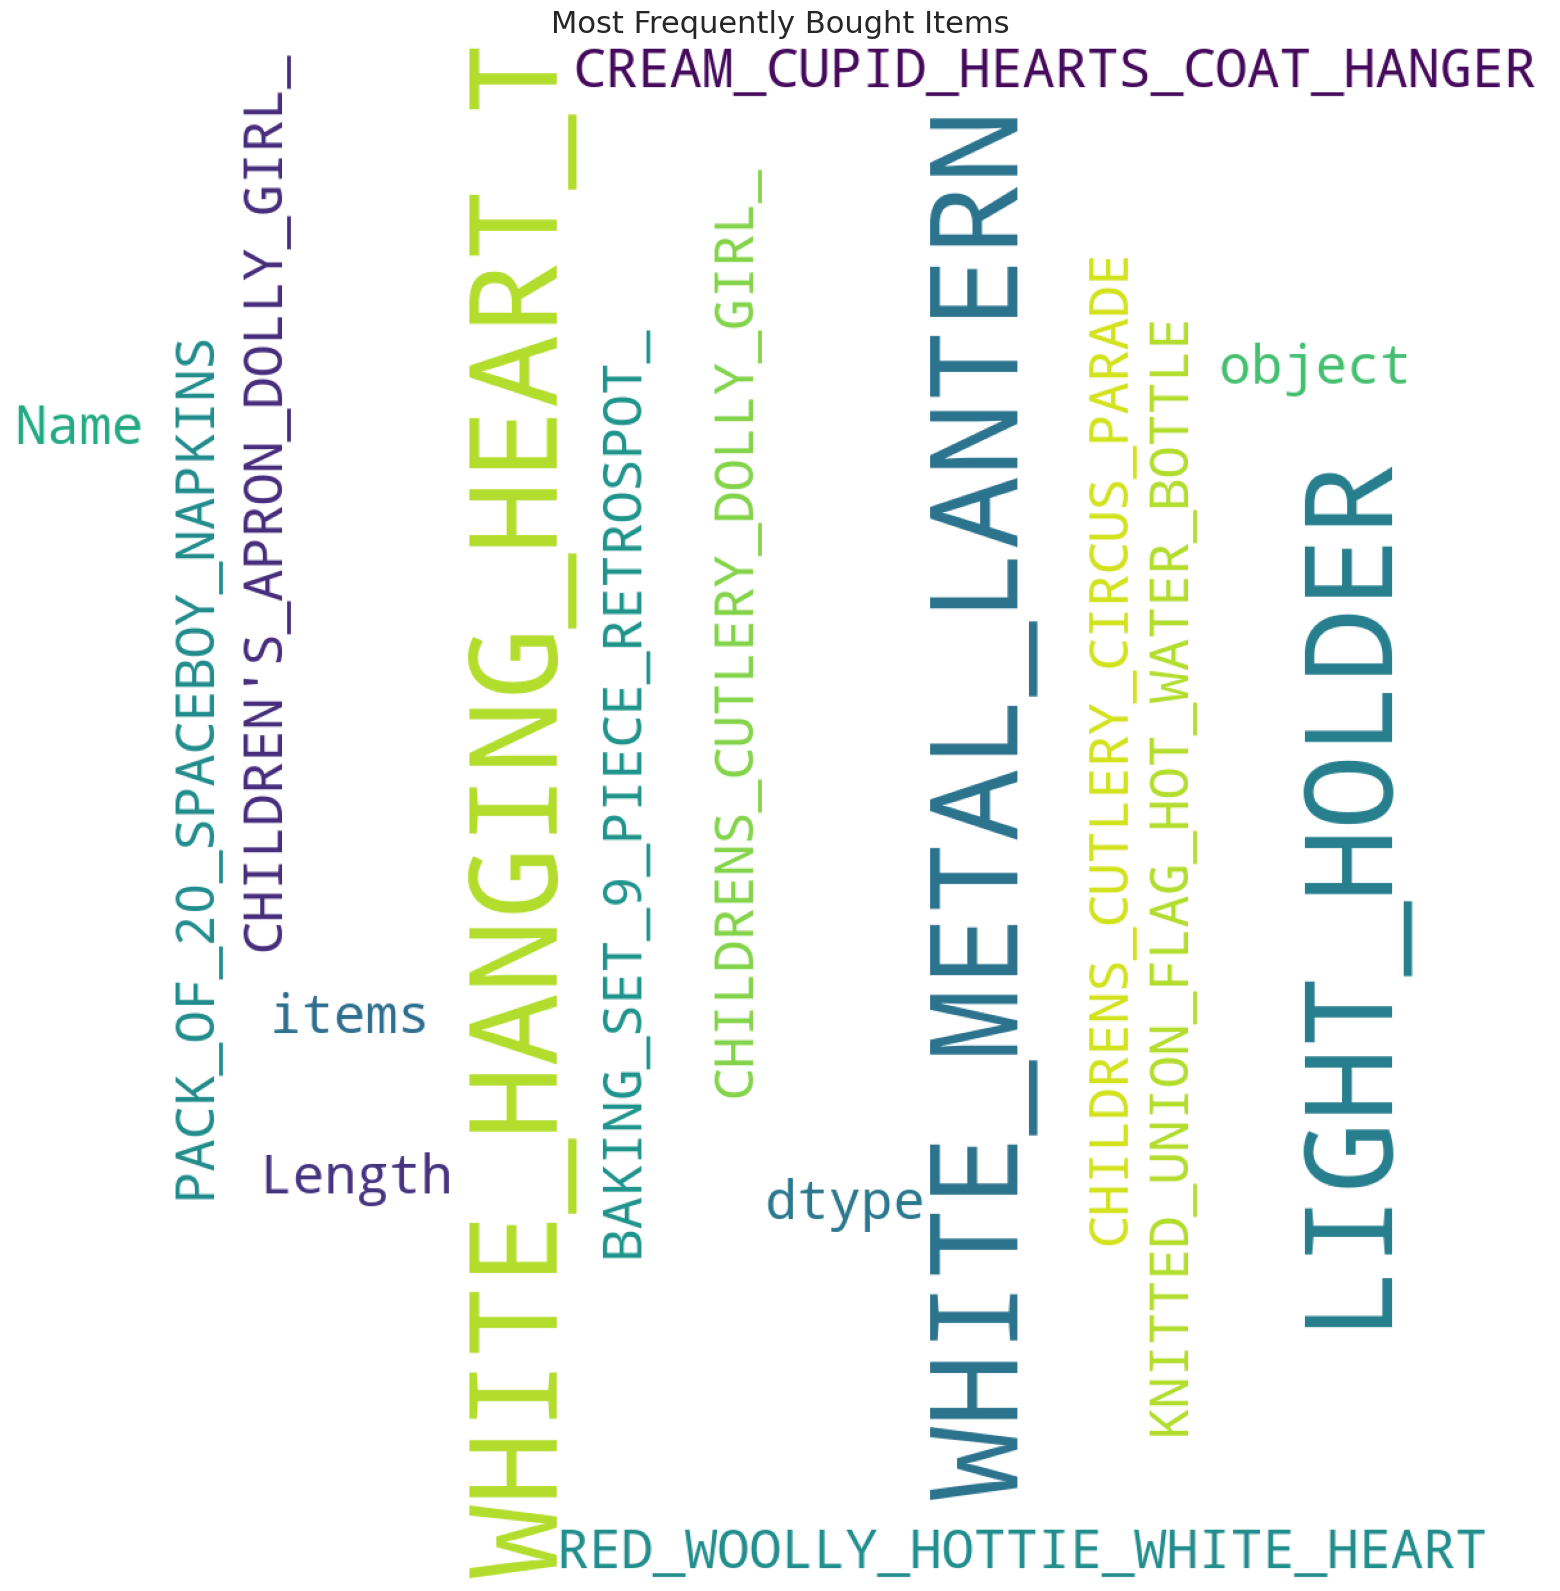

In [27]:
# Preparing data for wordcloud
df_new['items'] = df_new['Description'].str.replace(' ', '_') # combine words in the description as a one item

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (20, 20)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(df_new['items']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequently Bought Items',fontsize = 22)
plt.show()

#### 4.Items the are the most first choices

In [28]:
y = df_new['InvoiceNo']
y = y.to_list()
invoices = list(set(y))[:50] # selects only first 50 invoices to reduce the size of list

In [29]:
# Creating empty list first_choices
first_choices = []

# looping into list of unique invoice numbers
for i in invoices:
    
    # the first item (index = 0) of every invoice is the first purchase
    # extracting the item name for the first purchase
    first_purchase = df_new[df_new['InvoiceNo']==i]['items'].reset_index(drop=True)[0]
    
    # Appending the first purchase name into first choices list
    first_choices.append(first_purchase)

first_choices[:5]

['PAINTED_METAL_PEARS_ASSORTED',
 'LUNCH_BAG_SPACEBOY_DESIGN_',
 'METAL_DECORATION_NAUGHTY_CHILDREN_',
 'JUMBO_BAG_RED_RETROSPOT',
 'VINTAGE_DOILY_DELUXE_SEWING_KIT_']

In [30]:
count=Counter(first_choices)
# Storing the counter into a datafrane
df_first_choices = pd.DataFrame.from_dict(count, orient='index').reset_index()

# Rename columns as item and count
df_first_choices.rename(columns={'index':'item', 0:'count'},inplace=True)

# Sorting the df based on count
df_first_choices.sort_values(by='count',ascending=False)
print(df_first_choices['item'].to_list())

['PAINTED_METAL_PEARS_ASSORTED', 'LUNCH_BAG_SPACEBOY_DESIGN_', 'METAL_DECORATION_NAUGHTY_CHILDREN_', 'JUMBO_BAG_RED_RETROSPOT', 'VINTAGE_DOILY_DELUXE_SEWING_KIT_', 'SET/20_RED_RETROSPOT_PAPER_NAPKINS_', 'SPOTTY_BUNTING', 'STRAWBERRY___PICNIC_BAG', 'SET_OF_6_SPICE_TINS_PANTRY_DESIGN', 'SET_12_COLOUR_PENCILS_DOLLY_GIRL_', 'SET/3_RED_GINGHAM_ROSE_STORAGE_BOX', 'DANISH_ROSE_FOLDING_CHAIR', 'DOORMAT_NEW_ENGLAND', 'PINK_BLUE_FELT_CRAFT_TRINKET_BOX', 'KEY_FOB_,_BACK_DOOR_', 'JUMBO_BAG_OWLS', 'SET/6_RED_SPOTTY_PAPER_PLATES', 'ENAMEL_COLANDER_CREAM', 'PHOTO_FRAME_CORNICE', 'CHILDRENS_APRON_SPACEBOY_DESIGN', 'REGENCY_CAKESTAND_3_TIER', 'FOOD_COVER_WITH_BEADS_SET_2_', 'SET_6_PAPER_TABLE_LANTERN_STARS_', 'SET_OF_4_KNICK_KNACK_TINS_LEAVES_', 'DOORMAT_RED_RETROSPOT', 'REGENCY_TEA_PLATE_ROSES_', 'PLEASE_ONE_PERSON_METAL_SIGN', 'JAM_MAKING_SET_WITH_JARS', 'LUNCH_BAG_DOLLY_GIRL_DESIGN', 'LUNCH_BAG_DOILEY_PATTERN_', 'VINTAGE_RED_ENAMEL_TRIM_PLATE', 'DOORMAT_WELCOME_TO_OUR_HOME', 'BOUDOIR_SQUARE_TISSUE_B

## I. Implementation of the Rule Based Recommendation systems 
#### IA. Two types of rules are used in making recommedations here:
 - Popularity based rules
 - Buy again ( based on product purchase history) 

#### Popularity Based - Global Popularity of the product
Popularity of an items is calculated based on the total amount of the product/ items purchased worldwide. 

In [31]:
global_popularity=df_new.pivot_table(index=['StockCode','Description'],values='Quantity',aggfunc='sum').sort_values(by='Quantity',ascending=False)

print('Top 10 global popularity items are:')
global_popularity.head(10)
                                                                                             

Top 10 global popularity items are:


,,Quantity
StockCode,Description,
23843,"PAPER CRAFT , LITTLE BIRDIE",80995
23166,MEDIUM CERAMIC TOP STORAGE JAR,78033
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
85099B,JUMBO BAG RED RETROSPOT,48478
85123A,WHITE HANGING HEART T-LIGHT HOLDER,37603
22197,POPCORN HOLDER,36761
84879,ASSORTED COLOUR BIRD ORNAMENT,36461
21212,PACK OF 72 RETROSPOT CAKE CASES,36419
23084,RABBIT NIGHT LIGHT,30788


/tmp/ipykernel_8994/2810187554.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Description',x='Quantity',data=global_popularity.head(10),palette='coolwarm')


Text(0, 0.5, 'Item')

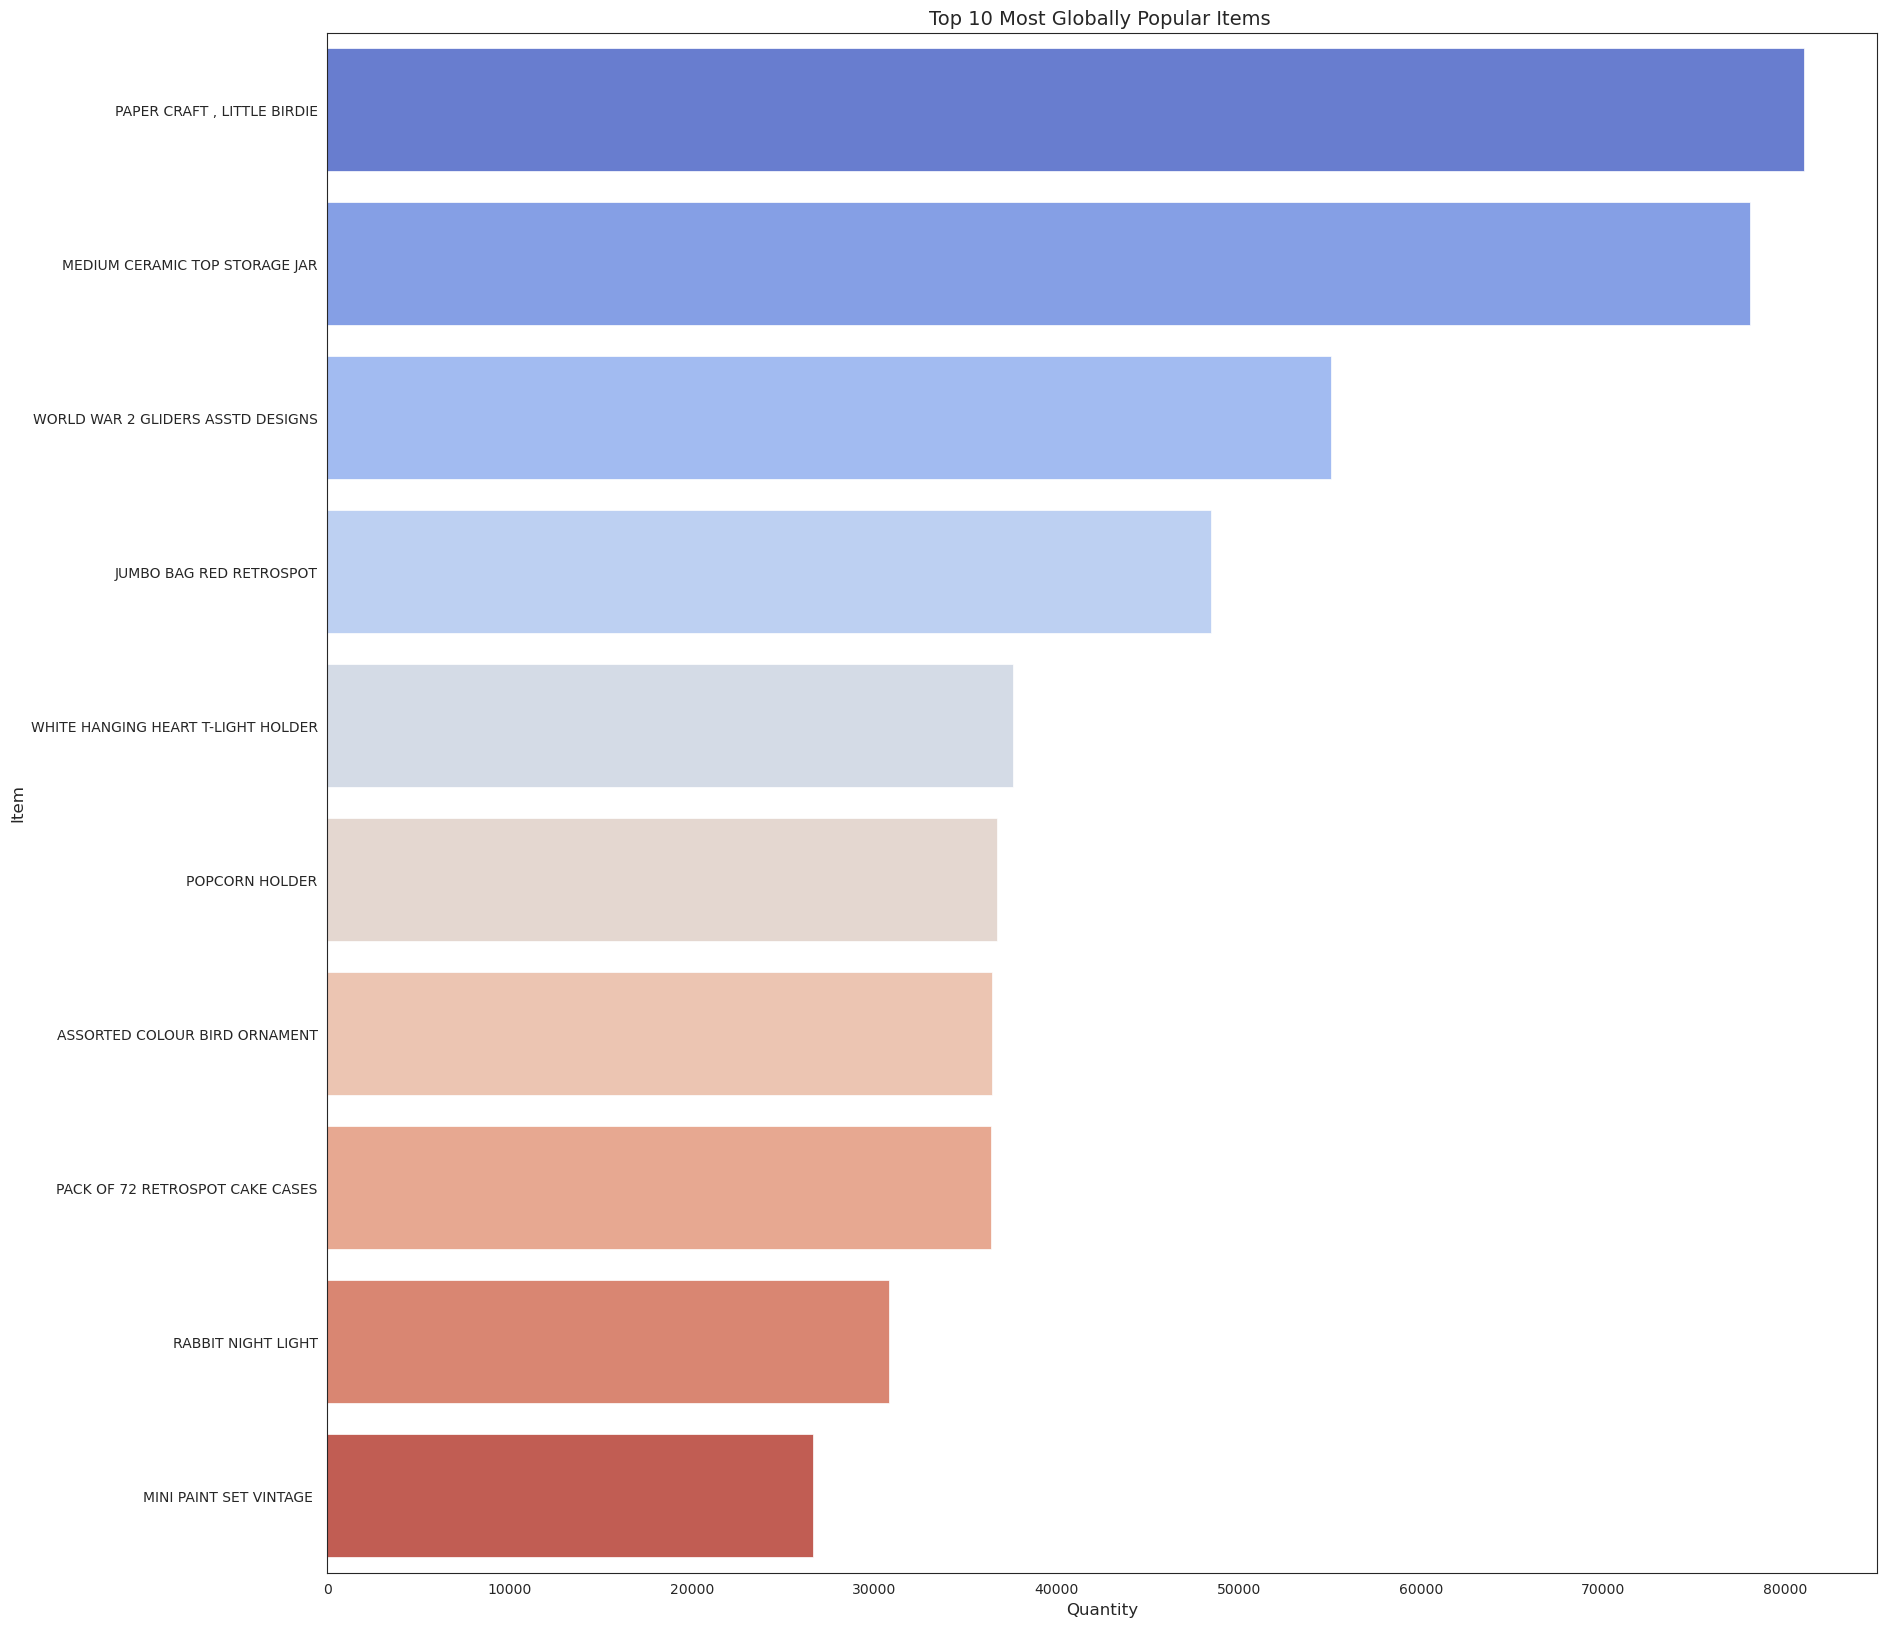

In [32]:
#plotting the top 10 globally popular items 
sns.barplot(y='Description',x='Quantity',data=global_popularity.head(10),palette='coolwarm')
plt.title('Top 10 Most Globally Popular Items ', fontsize=14)
plt.ylabel('Item')

#### Popularity Based - Country Based Popularity of the product

In [33]:
countrybased_df=df_new.pivot_table(index=['Country','StockCode','Description'],values='Quantity',aggfunc='sum').reset_index()
countrybased_df.head()

,Country,StockCode,Description,Quantity
0,Australia,15036,ASSORTED COLOURS SILK FAN,600
1,Australia,15056BL,EDWARDIAN PARASOL BLACK,3
2,Australia,16161P,WRAP ENGLISH ROSE,400
3,Australia,16169E,WRAP 50'S CHRISTMAS,25
4,Australia,20665,RED RETROSPOT PURSE,6


/tmp/ipykernel_8994/2470447778.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity',y='Description',data=countrybased_df[countrybased_df['Country']=='Australia'].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,0],palette='viridis')
/tmp/ipykernel_8994/2470447778.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity',y='Description',data=countrybased_df[countrybased_df['Country']=='United Kingdom'].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,1],palette='viridis')
/tmp/ipykernel_8994/2470447778.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue`

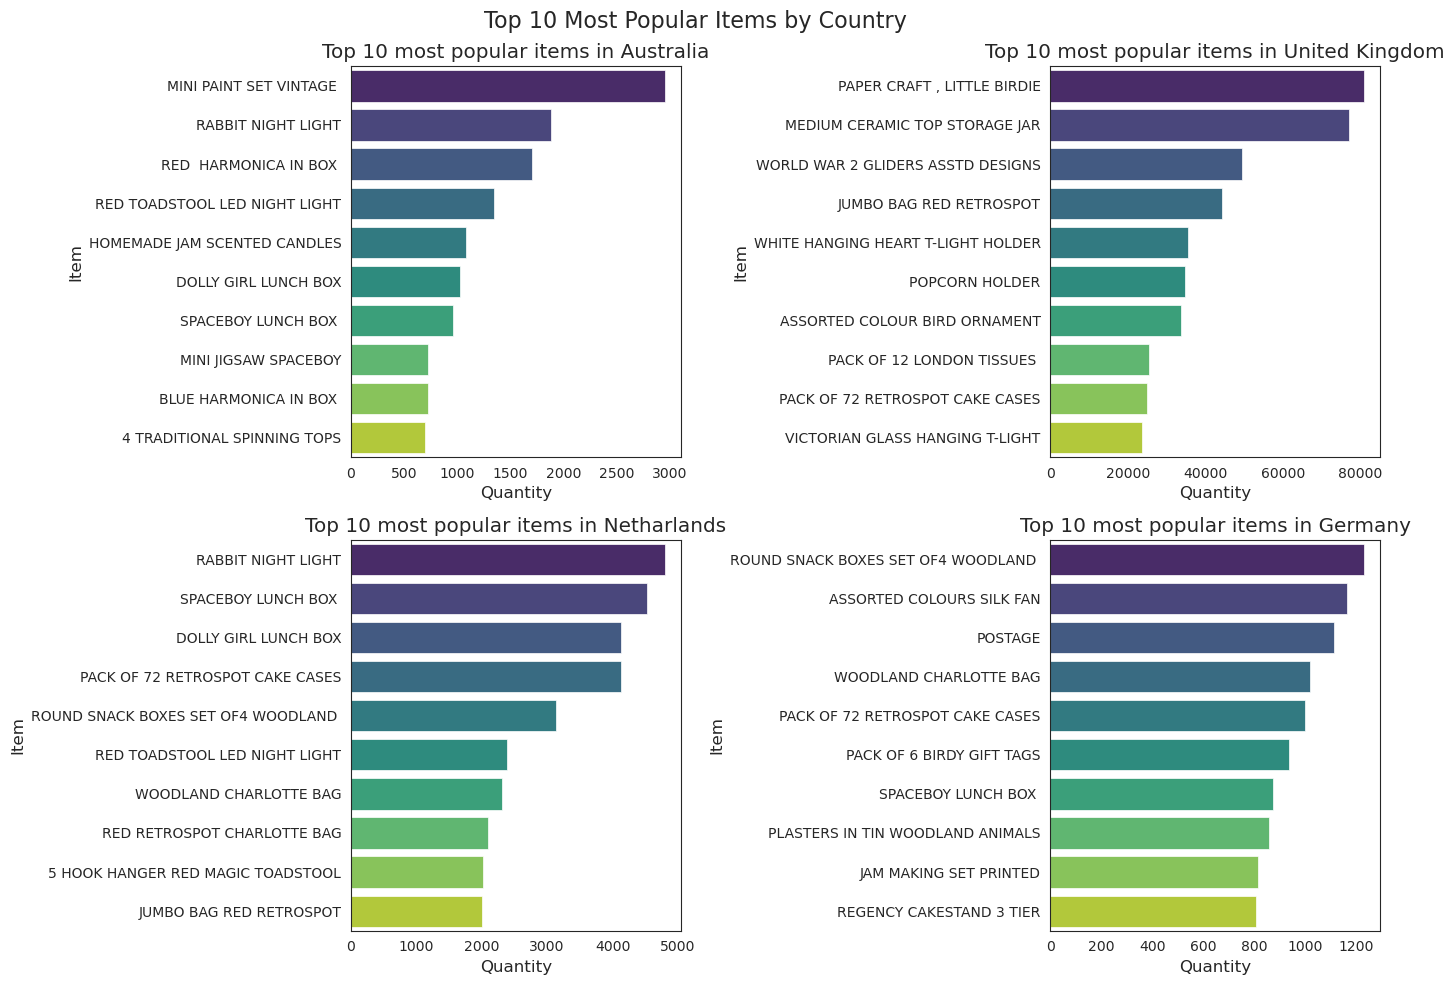

In [34]:
#plotting the top 10 popular items for selected countries 
fig,axes=plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Top 10 Most Popular Items by Country', fontsize=16)
#plot barplot for united Kingdom, Netherlands, Germany and Australia
sns.barplot(x='Quantity',y='Description',data=countrybased_df[countrybased_df['Country']=='Australia'].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,0],palette='viridis')
axes[0,0].set_title('Top 10 most popular items in Australia')
axes[0,0].set_ylabel('Item')

sns.barplot(x='Quantity',y='Description',data=countrybased_df[countrybased_df['Country']=='United Kingdom'].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,1],palette='viridis')
axes[0,1].set_title('Top 10 most popular items in United Kingdom')
axes[0,1].set_ylabel('Item')

sns.barplot(x='Quantity',y='Description',data=countrybased_df[countrybased_df['Country']=='Netherlands'].sort_values(by='Quantity', ascending=False).head(10),ax=axes[1,0],palette='viridis')
axes[1,0].set_title('Top 10 most popular items in Netharlands')
axes[1,0].set_ylabel('Item')

sns.barplot(x='Quantity',y='Description',data=countrybased_df[countrybased_df['Country']=='Germany'].sort_values(by='Quantity', ascending=False).head(10),ax=axes[1,1],palette='viridis')
axes[1,1].set_title('Top 10 most popular items in Germany')
axes[1,1].set_ylabel('Item')

plt.tight_layout()
plt.show()


### Popularity Based - Monthly Based Popularity of the product

/tmp/ipykernel_8994/3119817804.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity',y='Description',data=df_new[df_new['year_month']==201012].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,0],palette='coolwarm')
/tmp/ipykernel_8994/3119817804.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity',y='Description',data=df_new[df_new['year_month']==201101].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,1],palette='coolwarm')
/tmp/ipykernel_8994/3119817804.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect

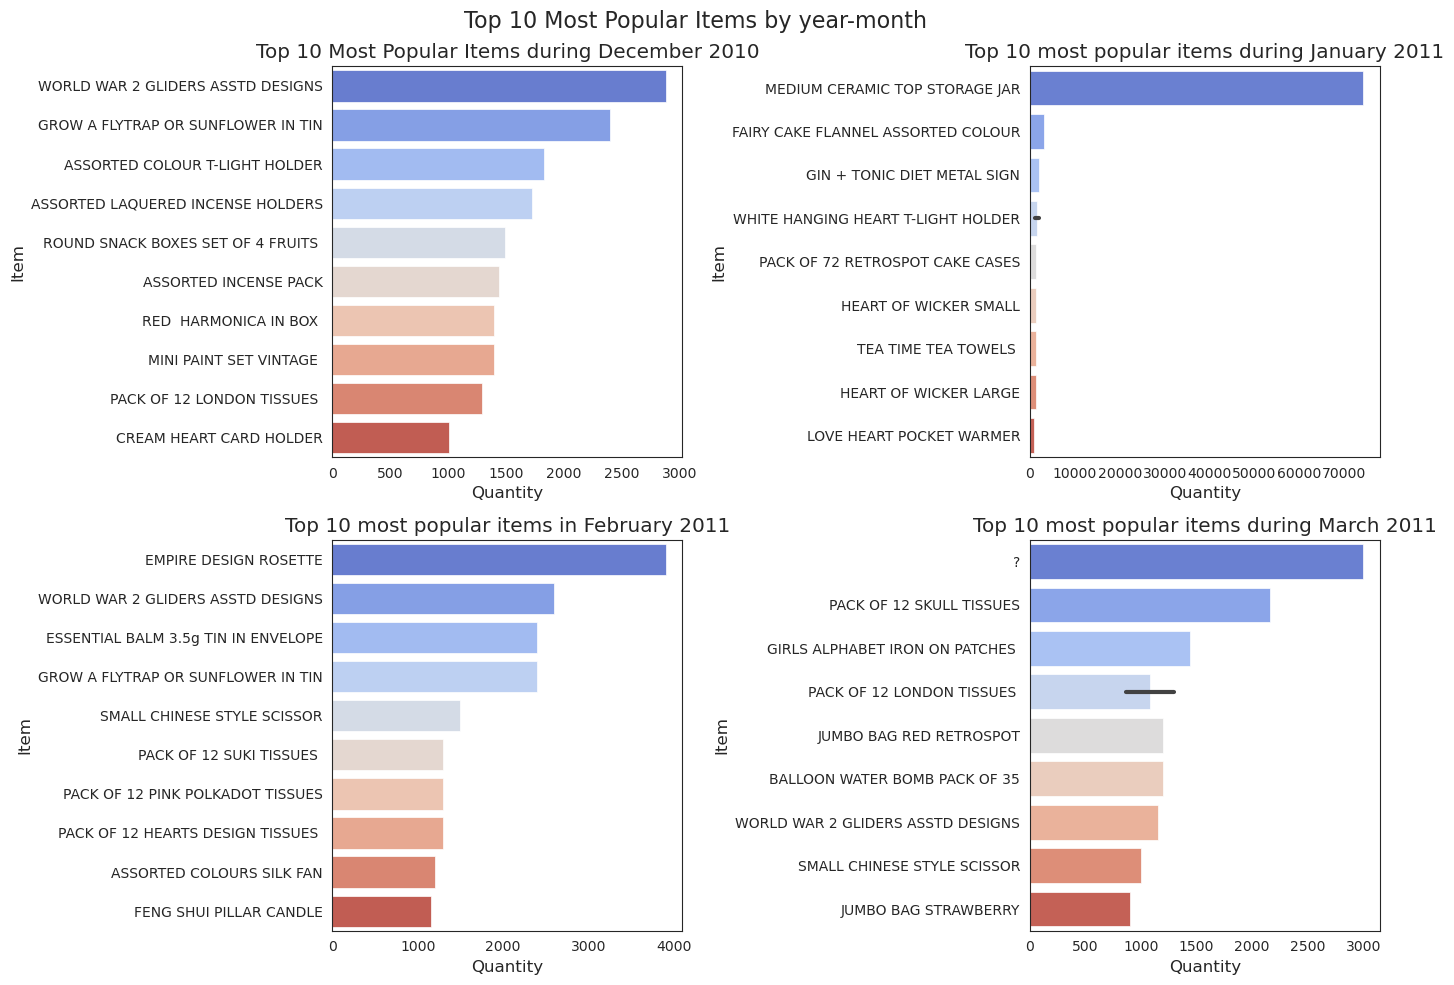

In [35]:
#plotting the top 10 popular items monthly based
fig,axes=plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Top 10 Most Popular Items by year-month', fontsize=16)
#plot barplot for united Kingdom, Netherlands, Germany and Australia
sns.barplot(x='Quantity',y='Description',data=df_new[df_new['year_month']==201012].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,0],palette='coolwarm')
axes[0,0].set_title('Top 10 Most Popular Items during December 2010')
axes[0,0].set_ylabel('Item')

sns.barplot(x='Quantity',y='Description',data=df_new[df_new['year_month']==201101].sort_values(by='Quantity', ascending=False).head(10),ax=axes[0,1],palette='coolwarm')
axes[0,1].set_title('Top 10 most popular items during January 2011')
axes[0,1].set_ylabel('Item')

sns.barplot(x='Quantity',y='Description',data=df_new[df_new['year_month']==201102].sort_values(by='Quantity', ascending=False).head(10),ax=axes[1,0],palette='coolwarm')
axes[1,0].set_title('Top 10 most popular items in February 2011')
axes[1,0].set_ylabel('Item')

sns.barplot(x='Quantity',y='Description',data=df_new[df_new['year_month']==201103].sort_values(by='Quantity', ascending=False).head(10),ax=axes[1,1],palette='coolwarm')
axes[1,1].set_title('Top 10 most popular items during March 2011')
axes[1,1].set_ylabel('Item')

plt.tight_layout()
plt.show()

### Buy Agains - based on customer's purchase history 

In [36]:
from collections import Counter
def buy_again(customerid):
    
    # Fetching the items bought by the customer for provided customer id
    items_bought = df_new[df_new['CustomerID']==customerid].Description    
 
   # Convert counter to list for printing recommendations
    buy_again_list = list(Counter(items_bought))
    
    # Printing the recommendations
    print('Items you would like to buy again :')
    return(buy_again_list)

In [37]:
buy_again(17850)

Items you would like to buy again :


['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'EDWARDIAN PARASOL RED',
 'RETRO COFFEE MUGS ASSORTED',
 'SAVE THE PLANET MUG',
 'VINTAGE BILLBOARD DRINK ME MUG',
 'VINTAGE BILLBOARD LOVE/HATE MUG',
 'WOOD 2 DRAWER CABINET WHITE FINISH',
 'WOOD S/3 CABINET ANT WHITE FINISH',
 'WOODEN PICTURE FRAME WHITE FINISH',
 'WOODEN FRAME ANTIQUE WHITE ',
 'EDWARDIAN PARASOL BLACK',
 'IVORY EMBROIDERED QUILT ',
 'JUMBO SHOPPER VINTAGE RED PAISLEY']

## II. Implementation of Market Basket Analysis in Recommendation systems

This is a data mining technique use in recommendar systems to identfy frequently bought itemsets by calculating the likelihood of buying the other items, when a certain item is being purchased by the customer in the same transaction/basket.

In [38]:
# creating the basket dataframe that specifies if an item is present in a specific invoice.
# Hence the goal is to check if a particular item was purchased or not, the values in the df are binary encoded
basket = (df_new.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket.head(10)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
def encode_units(x):
    if x < 1:
        return 0
    if x >= 1:
        return 1


basket = basket.applymap(encode_units)

/tmp/ipykernel_8994/379438731.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(encode_units)


 ### Applying Apirori Algorithm 

- support:  measures how frequently an itemset appears in the dataset.
- confidence : measures the likelihood of item B being bought when item A is bought.
- lift : Lift tells you how much more likely B is to be bought when A is bought, compared to random chance.
- Association Rules :finds relationships among large sets of data items to shows how frequently a itemset occurs in a transaction.

#### Implementation using mlxtend


#### Generation of the association rules
This generates a dataframe that contains columns ; "antecedents", "consequents", "support", "confidence", "lift".
- antecedents : items on the left side of the rule 
- consequents : items on the right side of the rule
- antecedent support : proportion of transactions contain antecedent
- consequent support : proportion of transactions contain consequent
- support : fraction of transactions contains both antecedents and consequents
- confidence: How often consequents appear in the transactions that contain antecedents
- lift : How likely consequents are to appear with  antecedents than by random chance

In [40]:
# trying out on a sample item
wooden_star_df = basket.loc[basket['WOODEN STAR CHRISTMAS SCANDINAVIAN']==1]
itemsets=apriori(wooden_star_df,min_support=0.5,use_colnames=True)
rules=association_rules(itemsets, metric='lift',min_threshold=1)
rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),1.000000,0.757812,0.757812,0.757812,1.0,0.0,1.0
1,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.757812,1.000000,0.757812,1.000000,1.0,0.0,inf
2,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN TREE CHRISTMAS SCANDINAVIAN),1.000000,0.548828,0.548828,0.548828,1.0,0.0,1.0
3,(WOODEN TREE CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.548828,1.000000,0.548828,1.000000,1.0,0.0,inf


In [41]:
# Creating a function to define frequntly bought itemsets 
def frequently_bought_together(item):
    # df of item passed
    item_df = basket.loc[basket[item]==1]
    frequent_itemsets=apriori(item_df,min_support=0.15,use_colnames=True)#Apply apriori algorithm on item df 
    rules=association_rules(frequent_itemsets,metric='lift',min_threshold=1)
    rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)
    return rules['consequents'].unique()[:6]
    

In [42]:
# Example 1
frequently_bought_together('WOODEN STAR CHRISTMAS SCANDINAVIAN')

array([frozenset({'12 PENCIL SMALL TUBE WOODLAND'}),
       frozenset({'WOODEN STAR CHRISTMAS SCANDINAVIAN'}),
       frozenset({'WOODEN HEART CHRISTMAS SCANDINAVIAN'}),
       frozenset({"3 RAFFIA RIBBONS 50'S CHRISTMAS "}),
       frozenset({'4 TRADITIONAL SPINNING TOPS'}),
       frozenset({'6 GIFT TAGS VINTAGE CHRISTMAS '})], dtype=object)

In [43]:
# Example 2
frequently_bought_together('WHITE METAL LANTERN')

array([frozenset({'DOTCOM POSTAGE'}),
       frozenset({'JUMBO BAG RED RETROSPOT'}),
       frozenset({'WHITE METAL LANTERN'}),
       frozenset({'ROSES REGENCY TEACUP AND SAUCER '}),
       frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),
       frozenset({'HEART OF WICKER LARGE'})], dtype=object)

In [44]:
#Validation of results gained by assosiation rules 
# JAM MAKING SET PRINTED is a part of invoice 536390, so cross-check itemsets for invoice 536390  
df_new[df_new['InvoiceNo']=='536390']


,InvoiceNo,StockCode,year_month,month,day,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,items
211,536390,22941,201012,12,3,CHRISTMAS LIGHTS 10 REINDEER,2,2010-12-01 10:19:00,8.50,17511.0,United Kingdom,17.00,CHRISTMAS_LIGHTS_10_REINDEER
212,536390,22960,201012,12,3,JAM MAKING SET WITH JARS,12,2010-12-01 10:19:00,3.75,17511.0,United Kingdom,45.00,JAM_MAKING_SET_WITH_JARS
213,536390,22961,201012,12,3,JAM MAKING SET PRINTED,12,2010-12-01 10:19:00,1.45,17511.0,United Kingdom,17.40,JAM_MAKING_SET_PRINTED
214,536390,22962,201012,12,3,JAM JAR WITH PINK LID,48,2010-12-01 10:19:00,0.72,17511.0,United Kingdom,34.56,JAM_JAR_WITH_PINK_LID
215,536390,22963,201012,12,3,JAM JAR WITH GREEN LID,48,2010-12-01 10:19:00,0.72,17511.0,United Kingdom,34.56,JAM_JAR_WITH_GREEN_LID
216,536390,22968,201012,12,3,ROSE COTTAGE KEEPSAKE BOX,8,2010-12-01 10:19:00,8.50,17511.0,United Kingdom,68.00,ROSE_COTTAGE_KEEPSAKE_BOX_
217,536390,84970S,201012,12,3,HANGING HEART ZINC T-LIGHT HOLDER,144,2010-12-01 10:19:00,0.64,17511.0,United Kingdom,92.16,HANGING_HEART_ZINC_T-LIGHT_HOLDER
218,536390,22910,201012,12,3,PAPER CHAIN KIT VINTAGE CHRISTMAS,40,2010-12-01 10:19:00,2.55,17511.0,United Kingdom,102.00,PAPER_CHAIN_KIT_VINTAGE_CHRISTMAS
219,536390,20668,201012,12,3,DISCO BALL CHRISTMAS DECORATION,288,2010-12-01 10:19:00,0.10,17511.0,United Kingdom,28.80,DISCO_BALL_CHRISTMAS_DECORATION
220,536390,85123A,201012,12,3,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511.0,United Kingdom,163.20,WHITE_HANGING_HEART_T-LIGHT_HOLDER


There are a couple of common items between the recommendations from frequently_bought_together and the chosen invoice id.Thus we can say the recommender is performing well

#### Visualization of association Rules 

In [47]:
# Use sample 
support=rules.support.values
confidence=rules.confidence.values

In [48]:
import networkx as nx

In [49]:
import random 
import matplotlib.pyplot as plt 

for i in range (len(support)):
    support[i]=support[i]
    

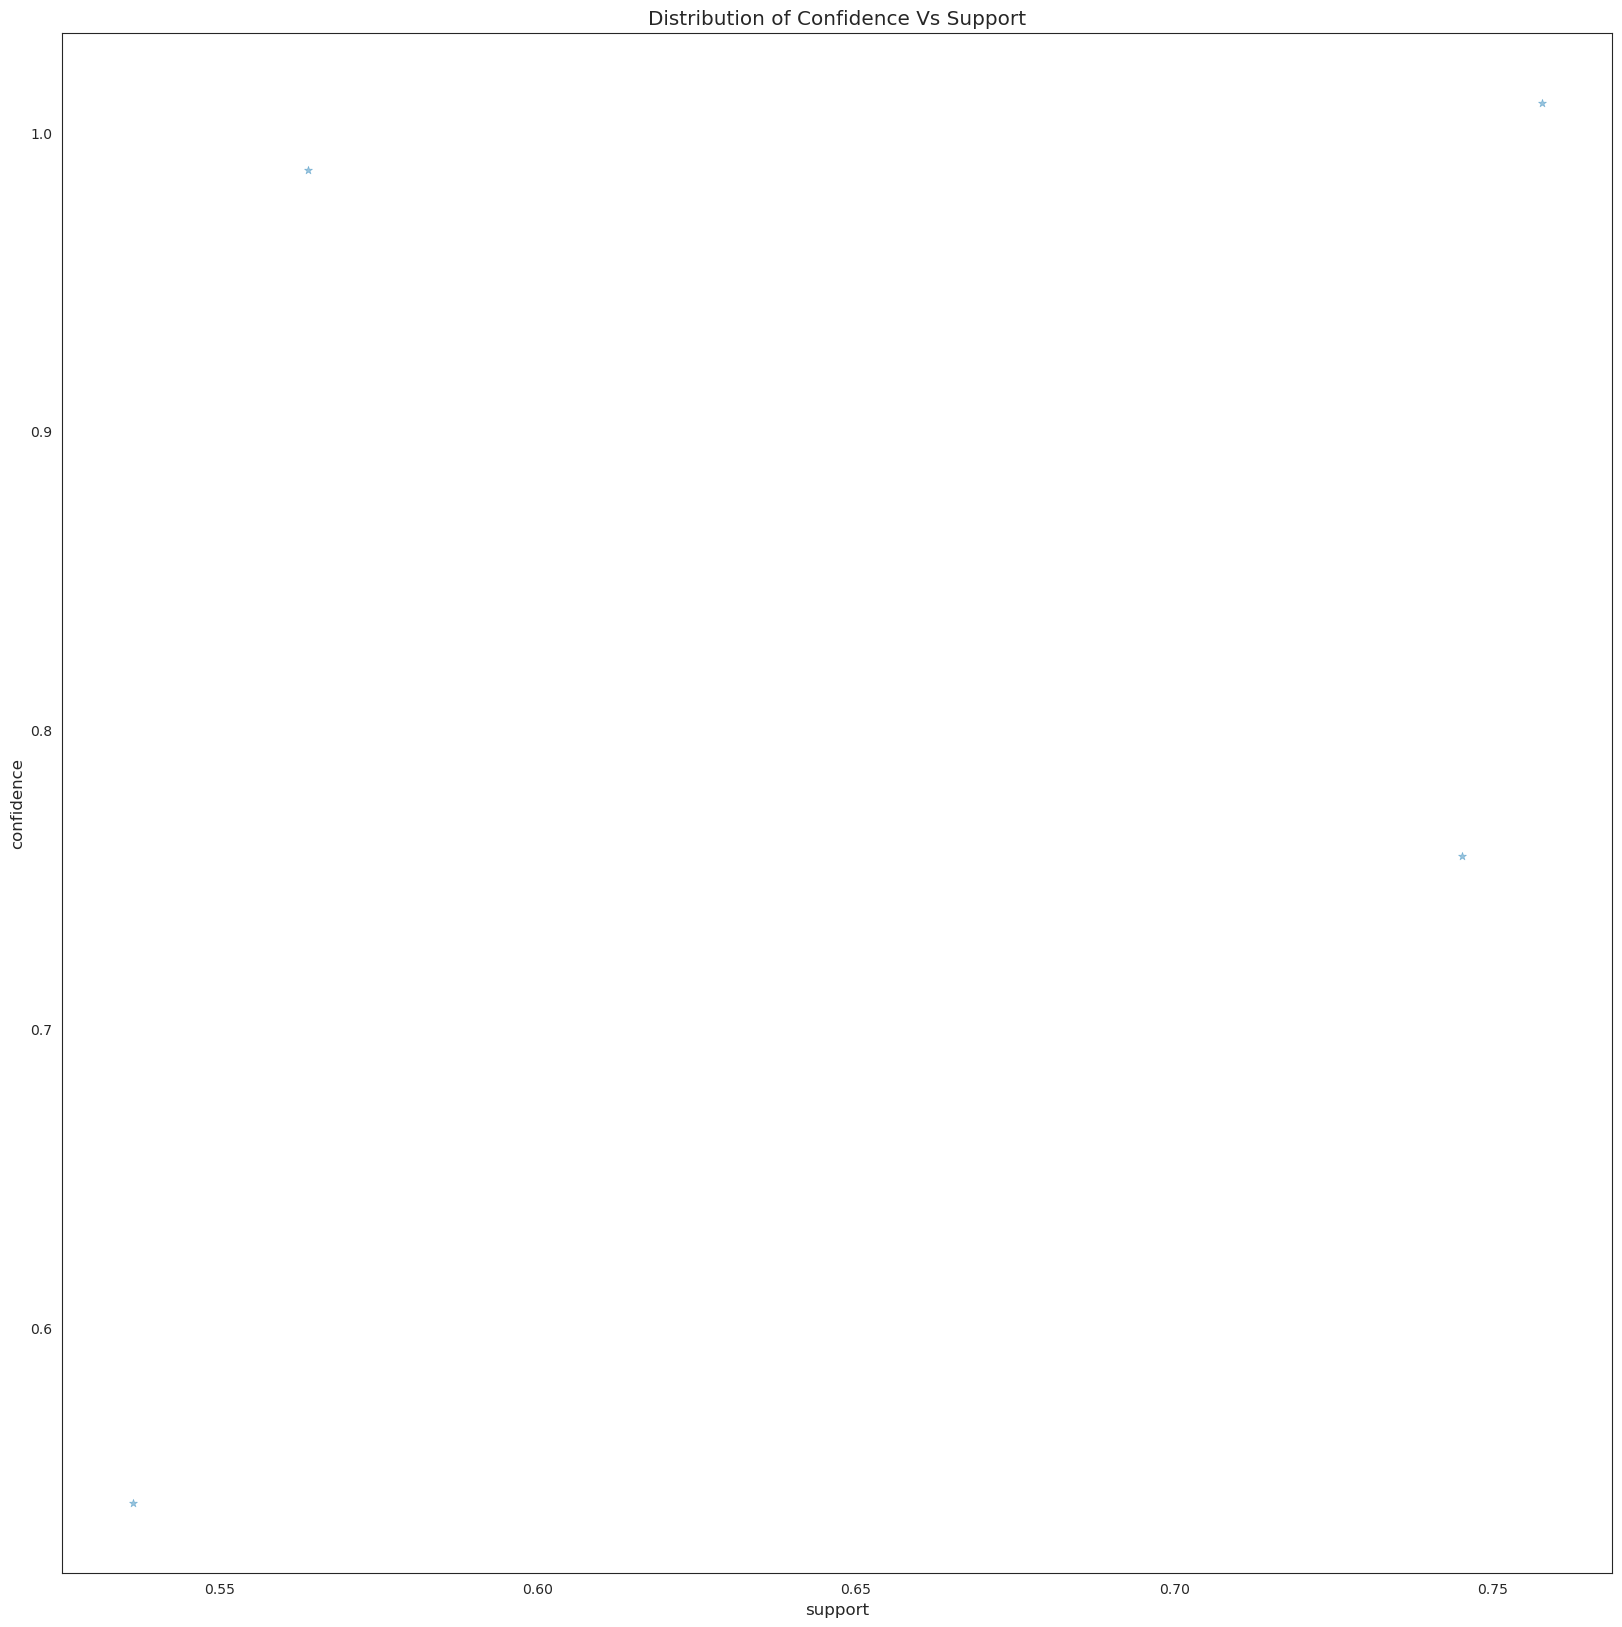

In [51]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5)  # adds a noise to make points visually distinguishable
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)

# Creating a scatter plot of support v confidence    
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.title('Distribution of Confidence Vs Support')
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [72]:
def wooden_star_graph(rules, no_of_rules):
  G1 = nx.DiGraph() 
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']     
   
   
  for i in range(len(rules)):      
    
   
    G1.add_nodes_from(["R"+str(i)]) # Add rule nodes as number of rules decided by the user 
    
     #Add item nodes to the graph ( both antecedent and consequnets)
      
    for a in rules.iloc[i]['antecedents']:
        G1.add_nodes_from([a]) # add antecedents nodes
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)# add edges to the antecedent nodes 
    

    for c in rules.iloc[i]['consequents']:
        G1.add_nodes_from([c]) # add consequents nodes 
        G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)# add edges to the consequent nodes 
 
  
    for node in G1:
       found_a_string = False # checks of the current node matches any of the rule nodes in the strs
       for item in strs: # loop through the rule nodes
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')# Rule nodes are colored yellow 
       else:
            color_map.append('green') # All other nodes are colored green       
 
 
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

 # generate nodes positions using the layout algorithm 
  pos = nx.spring_layout(G1, k=16, scale=1)# k controls the spacing between the nodes 

 # draw the graph 
  nx.draw_networkx_nodes(G1, pos, node_color=color_map)
  nx.draw_networkx_edges(G1, pos, edge_color=colors, width=weights)
  nx.draw_networkx_labels(G1, pos, font_size=16)
  
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos) # add labels to nodes with adjusetd positions in pos
  plt.show()